In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sympy.abc import a,b,c,w,x,y,z,g,h
import sympy as sp
from scipy.signal import find_peaks
from parameters import *

In [2]:
def s21_symbolic(w, H, **kwargs):
    gamma_1 = kwargs.get('gamma_1', a)
    gamma_2 = kwargs.get('gamma_2', b)
    gamma_r = kwargs.get('gamma_r', c)
    alpha_1 = kwargs.get('alpha_1', 0)
    alpha_2 = kwargs.get('alpha_2', 0)
    alpha_r = kwargs.get('alpha_r', 0)
    omega_1 = kwargs.get('omega_1', x)
    omega_2 = kwargs.get('omega_2', y)
    omega_r = kwargs.get('omega_r', z)
    g1 = kwargs.get('g1', g)
    g2 = kwargs.get('g2', h)
    tomega_1 = omega_1 - 1j*(alpha_1+gamma_1)
    tomega_2 = omega_2 - 1j*(alpha_2+gamma_2)
    tomega_r = omega_r - 1j*(alpha_r+gamma_r)


    M = sp.Matrix([[w-tomega_1,-g1+1j*sp.sqrt(gamma_1*gamma_r),1j*sp.sqrt(gamma_1*gamma_2)],[-g1+1j*sp.sqrt(gamma_1*gamma_r),w-tomega_r,-g2+1j*sp.sqrt(gamma_2*gamma_r)],[1j*sp.sqrt(gamma_1*gamma_2),-g2+1j*sp.sqrt(gamma_2*gamma_r),w-tomega_2]]) * 1j
    B = sp.Matrix([[sp.sqrt(gamma_1), sp.sqrt(gamma_r), sp.sqrt(gamma_2)]]).T * sp.sqrt(2)
    return M

s21_symbolic(w, 1)#, gamma_1=a, gamma_2=b, gamma_r=c,))

Matrix([
[     1.0*I*(1.0*I*a + w - x), 1.0*I*(-g + 1.0*I*sqrt(a*c)),               -1.0*sqrt(a*b)],
[1.0*I*(-g + 1.0*I*sqrt(a*c)),      1.0*I*(1.0*I*c + w - z), 1.0*I*(-h + 1.0*I*sqrt(b*c))],
[              -1.0*sqrt(a*b), 1.0*I*(-h + 1.0*I*sqrt(b*c)),      1.0*I*(1.0*I*b + w - y)]])

In [10]:
def s21(w, H, **kwargs):
    gyro1 = kwargs.get('gyro1', 2.94e-3)
    gyro2 = kwargs.get('gyro2', 1.76e-2/2/np.pi)
    M1 = kwargs.get('M1', 10900) # Py
    M2 = kwargs.get('M2', 1750) # YIG

    gamma_1 = kwargs.get('gamma_1', .0001)
    gamma_2 = kwargs.get('gamma_2', .008)
    gamma_r = kwargs.get('gamma_r', .02)

    alpha_1 = kwargs.get('alpha_1', 0)
    alpha_2 = kwargs.get('alpha_2', 0)
    alpha_r = kwargs.get('alpha_r', 0)

    omega_1 = gyro1*np.sqrt(H*(H+M1))
    omega_2 = gyro2*np.sqrt(H*(H+M2))
    omega_r = kwargs.get('omega_r', 5.3)

    g1 = kwargs.get('g1', .1)
    g2 = kwargs.get('g2', .1)

    tomega_1 = omega_1 - 1j*(alpha_1+gamma_1)
    tomega_2 = omega_2 - 1j*(alpha_2+gamma_2)
    tomega_r = omega_r - 1j*(alpha_r+gamma_r)


    M = np.array([[w-tomega_1,-g1+1j*np.sqrt(gamma_1*gamma_r),1j*np.sqrt(gamma_1*gamma_2)],[-g1+1j*np.sqrt(gamma_1*gamma_r),w-tomega_r,-g2+1j*np.sqrt(gamma_2*gamma_r)],[1j*np.sqrt(gamma_1*gamma_2),-g2+1j*np.sqrt(gamma_2*gamma_r),w-tomega_2]]) * 1j
    B = np.array([[np.sqrt(gamma_1), np.sqrt(gamma_r), np.sqrt(gamma_2)]]).T * np.sqrt(2)

    return B.T @ np.linalg.inv(M) @ B
    # return M

# print(s21(5.4, 1))#, gamma_1=a, gamma_2=b, gamma_r=c,)


def plot_s21(H, **kwargs):
    w = np.linspace(5, 5.6, 3000)
    s21s = [s21(ww, H, **kwargs)[0, 0] for ww in w]
    abs_s21 = np.abs(s21s)

    # Find peaks
    peaks, _ = find_peaks(abs_s21, height=0.5)
    if len(peaks) < 2:
        print("Less than two peaks found.")
        return

    # Get x (frequency) positions of the two highest peaks
    top_peaks = peaks[np.argsort(abs_s21[peaks])][-2:]
    top_peaks = np.sort(top_peaks)
    x1, x2 = w[top_peaks[0]], w[top_peaks[1]]

    # Set y-position for the red line a bit below the smaller peak
    y_line = min(abs_s21[top_peaks]) * 0.95

    plt.figure(figsize=(8, 6))
    plt.plot(w, abs_s21)
    plt.title(f'H={H} Oe')
    plt.xlabel('$\\omega$ (GHz)', fontsize=16)
    plt.ylabel('$|S_{21}|$', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=15)

    # Draw red line showing coupling strength
    plt.hlines(y=y_line, xmin=x1, xmax=x2, colors='red', linewidth=2)
    plt.text((x1 + x2) / 2, y_line - 0.1, 'coupling strength',
             color='red', fontsize=12, ha='center')

    plt.tight_layout()
    plt.savefig(f"..\\images\\H={H}Oe_coupling_strength.png")
    plt.close()


def plot_2d_s21(**kwargs):
    w = np.linspace(5,5.6,500)
    H = np.linspace(0, 1.6, 1500)*1e3
    plt.figure(figsize=(8, 6))
    s21s = np.array([[s21(ww, hh, **kwargs)[0,0] for hh in H] for ww in w])
    plt.pcolormesh(H, w, np.abs(s21s))#, extent=[w[0], w[-1], H[0], H[-1]], aspect='auto')
    plt.vlines(300, w[0], w[-1], color='r', linestyle='--')
    plt.vlines(1200, w[0], w[-1], color='r', linestyle='--')
    plt.xlabel('H (Oe)',fontsize=16)
    plt.ylabel('$\\omega$ (GHz)',fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=8)
    plt.tight_layout()
    # plt.show()
    plt.savefig("s21_selections.png")
    plt.close()

HH1, HH2 = 300, 1200

# plot_2d_s21()
plot_s21(HH1)
plot_s21(HH2)

In [4]:
def s21_couplings(**kwargs):
    w = np.linspace(5,5.6,500)
    s21_1 = np.array([np.abs(s21(ww, HH1, **kwargs)[0,0]) for ww in w])
    s21_2 = np.array([np.abs(s21(ww, HH2, **kwargs)[0,0]) for ww in w])

    peak_indices_1 = np.where((s21_1[1:-1] > s21_1[:-2]) & (s21_1[1:-1] > s21_1[2:]))[0] + 1
    peak_x_values_1 = w[peak_indices_1]
    peak_diff_1 = np.diff(peak_x_values_1)
    # print("Differences between peaks in s21_1:", peak_diff_1)

    peak_indices_2 = np.where((s21_2[1:-1] > s21_2[:-2]) & (s21_2[1:-1] > s21_2[2:]))[0] + 1
    peak_x_values_2 = w[peak_indices_2]
    peak_diff_2 = np.diff(peak_x_values_2)

    if len(peak_diff_1) == 0:
        # print(peak_x_values_1)
        peak_diff_1 = [0]
    if len(peak_diff_2) == 0:
        # print(peak_x_values_2)
        peak_diff_2 = [0]

    # print("Differences between peaks in s21_1:", peak_diff_2)
    # return s21s
    return peak_diff_1, peak_diff_2

s21_couplings(g1=.1,g2=.1)

(array([0.21763527]), array([0.20200401]))

In [5]:
l1_arr = np.linspace(0,.31/2**.5,150)
# gamma1_arr = 2*np.pi*l1_arr**2
axis_resolution = 80
limits = .1
gamma1_arr = np.linspace(0.01,.05,axis_resolution)*1e-2
gamma2_arr = np.linspace(0.01,.05,axis_resolution)*1e-5
# gamma2_arr = 2*np.pi*l2_arr**2
# gamma2_arr = np.linspace(0.05,.15,50)
diffs = np.array([[s21_couplings(alpha_1=gamma1, alpha_2=gamma2) for gamma1 in gamma1_arr] for gamma2 in gamma2_arr])[...,0]
# diffs = np.array([[s21_couplings(g1=l1, l2=l2) for l1 in l1_arr] for l2 in l2_arr])[...,0]

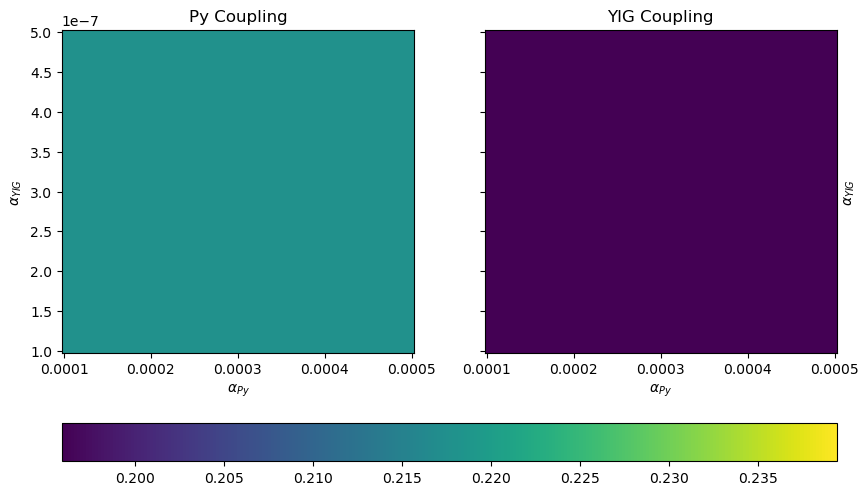

In [6]:
import os
fig, axs = plt.subplots(1,2,sharey=True,figsize=(10,6))
axs[0].pcolormesh(gamma1_arr, gamma2_arr, diffs[...,0])
axs[0].set_xlabel('$\\alpha_{Py}$')
axs[0].set_ylabel('$\\alpha_{YIG}$')
# axs[0].title('Difference between peaks in s21_1')
# axs[0].colorbar()
# plt.show()
# print(diffs)
axs[1].pcolormesh(gamma1_arr, gamma2_arr, diffs[...,1])
axs[1].set_xlabel('$\\alpha_{Py}$')
axs[1].yaxis.set_label_position("right")
# axs[1].yaxis.tick_right()
axs[1].set_ylabel('$\\alpha_{YIG}$')
# axs[1].title('Difference between peaks in s21_2')
# axs[1].colorbar()
axs[0].set_title('Py Coupling')
# axs[0].plot(.08,1.9,'r.')
axs[1].set_title('YIG Coupling')
# fig.suptitle("Peak separation not affected by damping")
fig.colorbar(axs[0].collections[0], ax=axs, location="bottom", use_gridspec=False)
# fig.tight_layout()
plt.savefig('intrinsically_influenced_couplings.png')

In [7]:
g1_arr = np.linspace(.001,.2,10)
g2_arr = np.linspace(.001,.2,10)
diffs = np.array([[s21_couplings(g1=g1, g2=g2) for g1 in g1_arr] for g2 in g2_arr])[...,0]

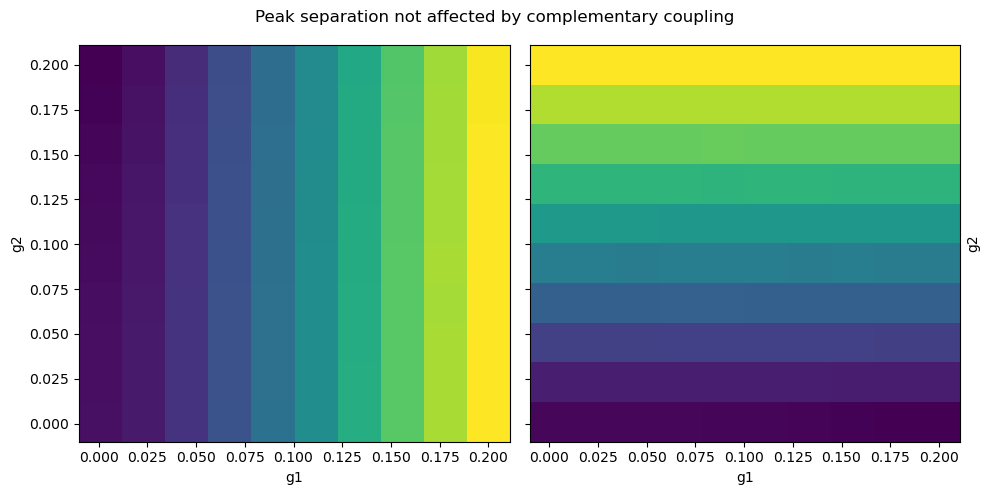

In [8]:
# print(diffs)
fig, axs = plt.subplots(1,2,sharey=True,figsize=(10,5))
axs[0].pcolormesh(g1_arr, g2_arr, diffs[...,0])
axs[0].set_xlabel('g1')
axs[0].set_ylabel('g2')
# axs[0].title('Difference between peaks in s21_1')
# axs[0].colorbar()
# plt.show()
# print(diffs)
axs[1].pcolormesh(g1_arr, g2_arr, diffs[...,1])
axs[1].set_xlabel('g1')
axs[1].yaxis.set_label_position("right")
# axs[1].yaxis.tick_right()
axs[1].set_ylabel('g2')
# axs[1].title('Difference between peaks in s21_2')
# axs[1].colorbar()
fig.suptitle("Peak separation not affected by complementary coupling")
fig.tight_layout()
plt.show()

In [9]:
l1_arr = np.linspace(0,.31/2**.5,150)
# gamma1_arr = 2*np.pi*l1_arr**2
gamma1_arr = np.linspace(0.05,.12,axis_resolution)
l2_arr = np.linspace(0,1,axis_resolution)
gamma2_arr = 2*np.pi*l2_arr**2
# gamma2_arr = np.linspace(0.05,.15,50)
diffs = np.array([[s21_couplings(gamma_1=gamma1, gamma_2=gamma2) for gamma1 in gamma1_arr] for gamma2 in gamma2_arr])[...,0]
# diffs = np.array([[s21_couplings(g1=l1, l2=l2) for l1 in l1_arr] for l2 in l2_arr])[...,0]

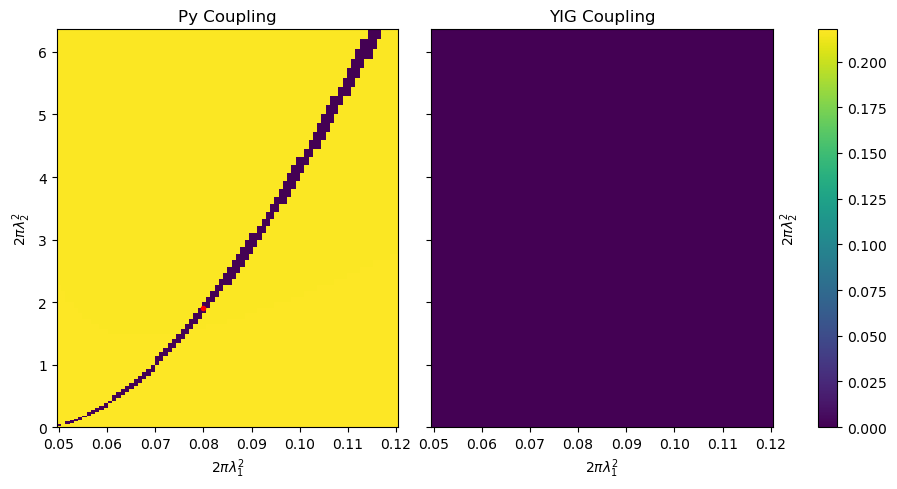

In [10]:
import os
fig, axs = plt.subplots(1,2,sharey=True,figsize=(10,5))
axs[0].pcolormesh(gamma1_arr, gamma2_arr, diffs[...,0])
axs[0].set_xlabel('$2\\pi\\lambda_1^2$')
axs[0].set_ylabel('$2\\pi\\lambda_2^2$')
# axs[0].title('Difference between peaks in s21_1')
# axs[0].colorbar()
# plt.show()
# print(diffs)
axs[1].pcolormesh(gamma1_arr, gamma2_arr, diffs[...,1])
axs[1].set_xlabel('$2\\pi\\lambda_1^2$')
axs[1].yaxis.set_label_position("right")
# axs[1].yaxis.tick_right()
axs[1].set_ylabel('$2\\pi\\lambda_2^2$')
# axs[1].title('Difference between peaks in s21_2')
# axs[1].colorbar()
axs[0].set_title('Py Coupling')
axs[0].plot(.08,1.9,'r.')
axs[1].set_title('YIG Coupling')
# fig.suptitle("Peak separation not affected by damping")
fig.tight_layout()
fig.colorbar(axs[0].collections[0], ax=axs, location="right", use_gridspec=False)
plt.savefig('couplings.png')

In [11]:
l1_arr = np.linspace(0,.31/2**.5,150)
# gamma1_arr = 2*np.pi*l1_arr**2
axis_resolution = 80
limits = .1
gamma1_arr2 = np.linspace(0,1,axis_resolution)*1e5
gamma2_arr2 = np.linspace(0,1,axis_resolution)*1e5
# gamma2_arr2 = 2*np.pi*l2_arr**2
# gamma2_arr2 = np.linspace(0.05,.15,50)
diffs2 = np.array([[s21_couplings(alpha_1=gamma1, alpha_2=gamma2) for gamma1 in gamma1_arr2] for gamma2 in gamma2_arr2])[...,0]
# diffs = np.array([[s21_couplings(g1=l1, l2=l2) for l1 in l1_arr] for l2 in l2_arr])[...,0]

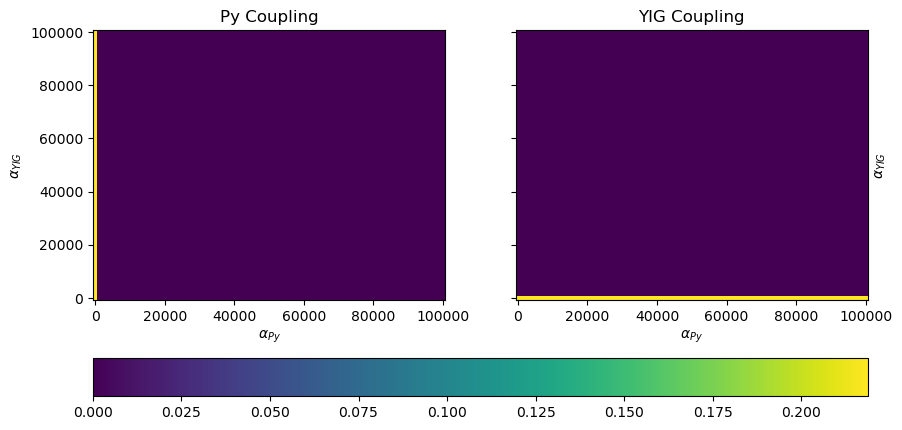

In [12]:
import os
fig, axs = plt.subplots(1,2,sharey=True,figsize=(10,5))
axs[0].pcolormesh(gamma1_arr2, gamma2_arr2, diffs2[...,0])
axs[0].set_xlabel('$\\alpha_{Py}$')
axs[0].set_ylabel('$\\alpha_{YIG}$')
# axs[0].title('Difference between peaks in s21_1')
# axs[0].colorbar()
# plt.show()
# print(diffs)
axs[1].pcolormesh(gamma1_arr2, gamma2_arr2, diffs2[...,1])
axs[1].set_xlabel('$\\alpha_{Py}$')
axs[1].yaxis.set_label_position("right")
# axs[1].yaxis.tick_right()
axs[1].set_ylabel('$\\alpha_{YIG}$')
# axs[1].title('Difference between peaks in s21_2')
# axs[1].colorbar()
axs[0].set_title('Py Coupling')
# axs[0].plot(.08,1.9,'r.')
axs[1].set_title('YIG Coupling')
# fig.suptitle("Peak separation not affected by damping")
fig.colorbar(axs[0].collections[0], ax=axs, location="bottom", use_gridspec=False)
# fig.tight_layout()
plt.savefig('intrinsically_influenced_couplings_wide.png')

In [13]:
l1_arr = np.linspace(0,.31/2**.5,150)
# gamma1_arr = 2*np.pi*l1_arr**2
axis_resolution = 40
limits = .1
gamma1_arr2 = np.linspace(0,1,axis_resolution)
gamma2_arr2 = np.linspace(0,.1,axis_resolution)
# gamma2_arr2 = 2*np.pi*l2_arr**2
# gamma2_arr2 = np.linspace(0.05,.15,50)
diffs2 = np.array([[s21_couplings(alpha_1=gamma1, alpha_2=gamma2) for gamma1 in gamma1_arr2] for gamma2 in gamma2_arr2])[...,0]
# diffs = np.array([[s21_couplings(g1=l1, l2=l2) for l1 in l1_arr] for l2 in l2_arr])[...,0]

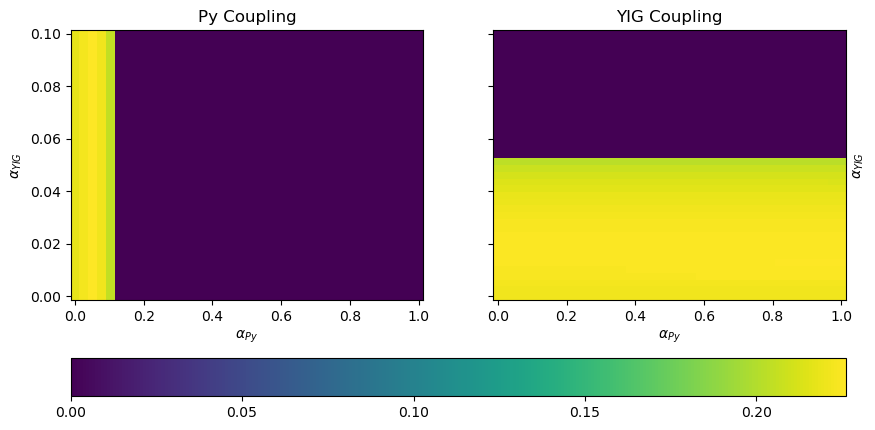

In [14]:
import os
fig, axs = plt.subplots(1,2,sharey=True,figsize=(10,5))
axs[0].pcolormesh(gamma1_arr2, gamma2_arr2, diffs2[...,0])
axs[0].set_xlabel('$\\alpha_{Py}$')
axs[0].set_ylabel('$\\alpha_{YIG}$')
# axs[0].title('Difference between peaks in s21_1')
# axs[0].colorbar()
# plt.show()
# print(diffs)
axs[1].pcolormesh(gamma1_arr2, gamma2_arr2, diffs2[...,1])
axs[1].set_xlabel('$\\alpha_{Py}$')
axs[1].yaxis.set_label_position("right")
# axs[1].yaxis.tick_right()
axs[1].set_ylabel('$\\alpha_{YIG}$')
# axs[1].title('Difference between peaks in s21_2')
# axs[1].colorbar()
axs[0].set_title('Py Coupling')
# axs[0].plot(.08,1.9,'r.')
axs[1].set_title('YIG Coupling')
# fig.suptitle("Peak separation not affected by damping")
fig.colorbar(axs[0].collections[0], ax=axs, location="bottom", use_gridspec=False)
# fig.tight_layout()
plt.savefig('intrinsically_influenced_couplings_wide.png')

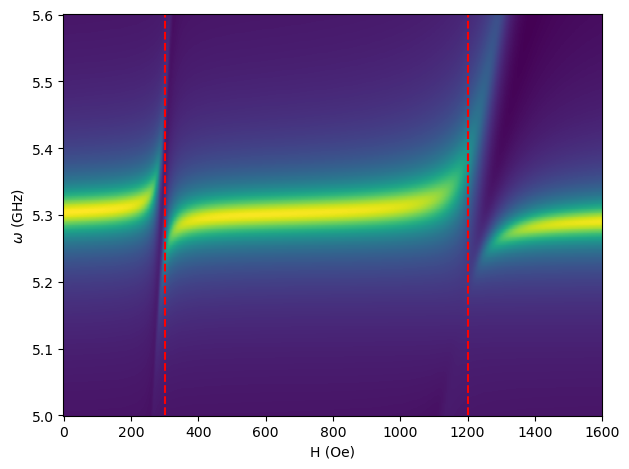

In [15]:
plot_2d_s21(alpha_1=.06, alpha_2=.06)


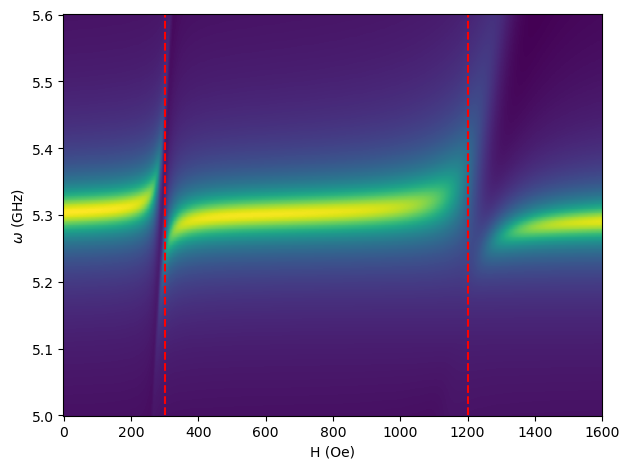

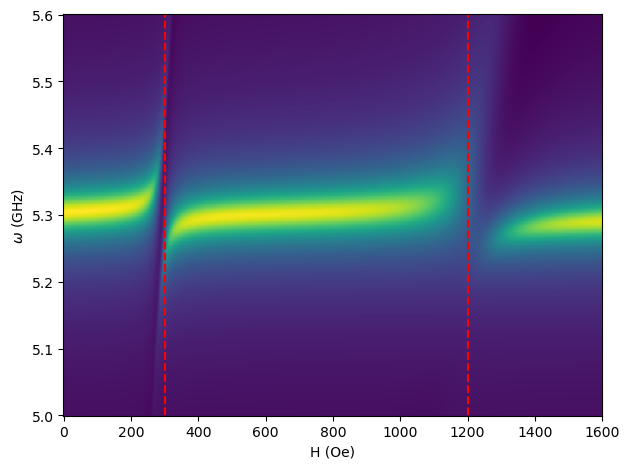

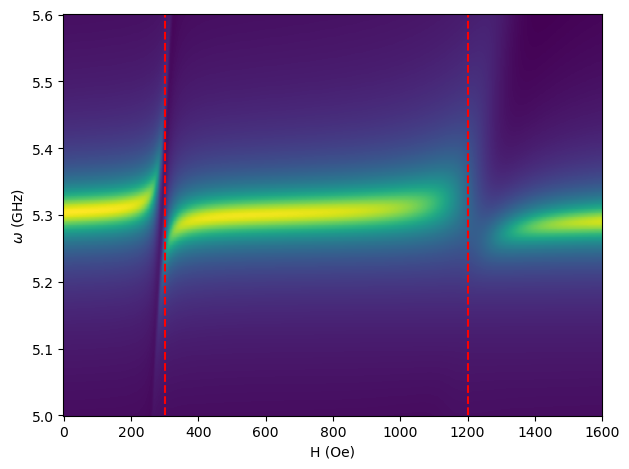

In [16]:
plot_2d_s21(alpha_1=.06, alpha_2=.12)
plot_2d_s21(alpha_1=.06, alpha_2=.16)
plot_2d_s21(alpha_1=.06, alpha_2=.2)

In [17]:
print(np.where(diffs[...,0]==0))

(array([ 5,  6,  7,  8,  9,  9, 10, 10, 11, 11, 12, 13, 14, 15, 15, 16, 16,
       17, 17, 18, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26,
       27, 27, 28, 28, 29, 29, 30, 30, 31, 32, 33, 33, 34, 34, 35, 35, 36,
       36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44,
       45, 45, 46, 46, 47, 47, 48, 48, 48, 49, 49, 49, 50, 50, 50, 51, 51,
       51, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 57, 57,
       58, 58, 59, 59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64,
       64, 64, 65, 65, 65, 66, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, 70,
       70, 70, 71, 71, 71, 72, 72, 72, 73, 73, 73, 74, 74, 74, 75, 75, 75,
       76, 76, 76, 77, 77, 77, 77, 78, 78, 78, 78, 79, 79, 79]), array([ 0,  0,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  7,  7,  8,  8,  9,
        9, 10, 10, 11, 11, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18,
       18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26,
       27, 27, 28, 28, 29, 29, 30,

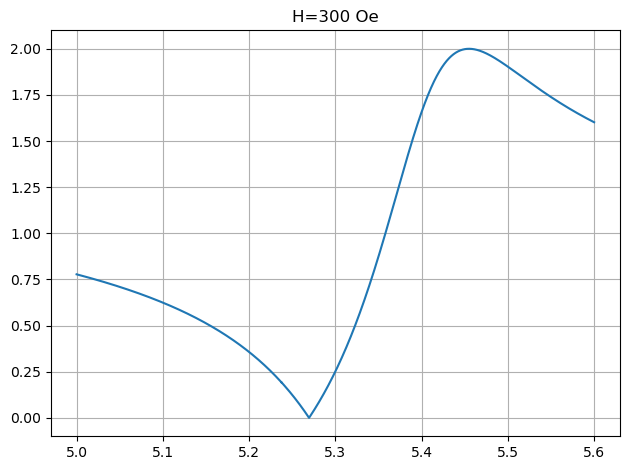

In [18]:
plot_s21(HH1, gamma_1=.08, gamma_2=1.9)

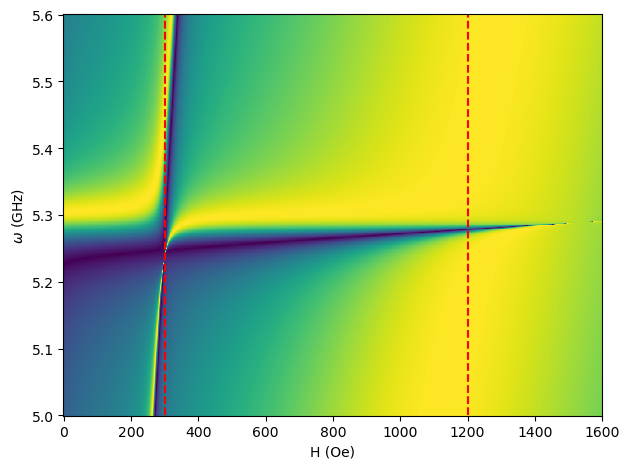

In [19]:
plot_2d_s21(gamma_1=.08, gamma_2=1.9)

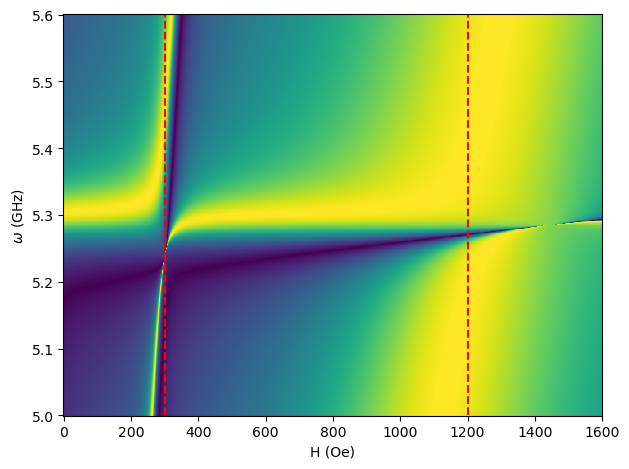

In [20]:
plot_2d_s21(gamma_1=.08, gamma_2=1)

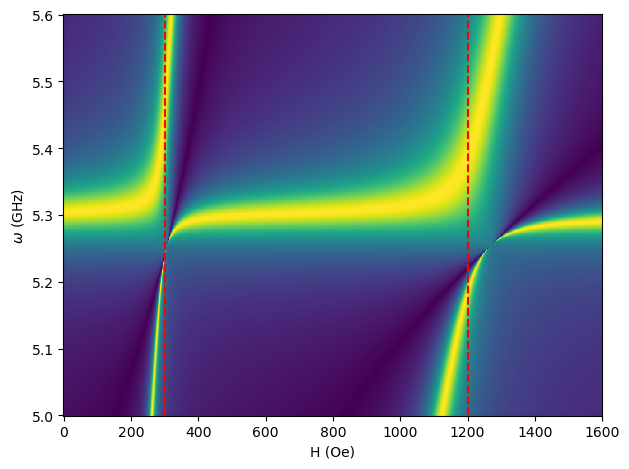

In [21]:
plot_2d_s21(gamma_1=.08, gamma_2=.1)